# CREDIT CARD KAAGLE DATASET

In [79]:
import os
import sys
import csv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import chi2
from sklearn.metrics.pairwise import pairwise_distances

import torch
import falkon

sys.path.insert(0, "../notebooks")
from plot_utils import plot_one_t


In [2]:
DATA_PATH = '../data/creditcard.csv'
df = pd.read_csv(DATA_PATH)

#normalize Time and Amount features
df['Time']   = (df['Time'] - df['Time'].mean()) / df['Time'].std()
df['Amount'] = (df['Amount'] - df['Amount'].mean()) / df['Amount'].std()

df_ref  = df[df['Class']==0]
df_data = df[df['Class']==1]

N_REF_TOT  = len(df_ref)
N_DATA_TOT = len(df_data)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996580,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996580,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342474,0
2,-1.996558,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160684,0
3,-1.996558,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996537,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [32]:
print(f'total number of transaction (data size): {N_REF_TOT+N_DATA_TOT}')
print(f'total number of reference transaction: {N_REF_TOT}')
print(f'total number of anomalous transaction: {N_DATA_TOT}, \n(ratio: {(N_DATA_TOT/N_REF_TOT)*100:.3f})%')

total number of transaction (data size): 284807
total number of reference transaction: 284315
total number of anomalous transaction: 492, 
(ratio: 0.173)%


### separate the features with the target

In [45]:
Ref  = df_ref[df_ref.columns[:-1]].to_numpy()
Data = df_data[df_data.columns[:-1]].to_numpy()

Target_Ref  = df_ref['Class'].to_numpy()
Target_Data = df_data['Class'].to_numpy()

print('feature reference shape:',Ref.shape)
print('feature data shape:\t',Data.shape)


feature reference shape: (284315, 30)
feature data shape:	 (492, 30)


### euclidean pair-wise distance

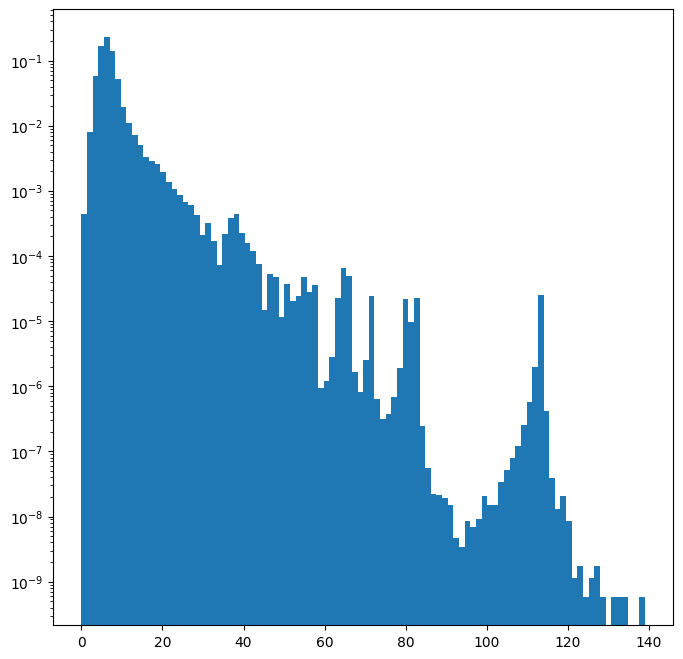

9.29291747901167
6.2929351001243905


In [30]:
subset = Ref[:50_000]

distances = pairwise_distances(subset, metric='euclidean')
plt.figure(figsize=(8,8))
plt.hist(distances.ravel(), bins=100, density=True)
plt.yscale('log')
plt.show()

quantile = np.quantile(distances, 0.90)
print(quantile)
print(np.median(distances))
del distances

## Define a model

In [72]:
# Statistics
N_REF      = 10_000
N_BKG      = 1_000
N_SIG      = 0  
# Samples weights N_D/N_R
N_R        = N_REF
N_D        = N_BKG

# select a random chosen subset of the dataset
idx_ref = np.random.choice(Ref.shape[0], N_REF+N_BKG, replace=False)
idx_sig = np.random.choice(Data.shape[0], N_SIG, replace=False)

feature_ref  = torch.from_numpy(Ref[idx_ref[:N_REF], :])
feature_bkg  = torch.from_numpy(Ref[idx_ref[N_REF:], :])
feature_sig  = torch.from_numpy(Data[idx_sig, :])
feature_data = torch.cat((feature_bkg, feature_sig), dim=0)

target_ref  = torch.zeros((N_REF, 1), dtype=torch.float64)
target_data = torch.ones((N_BKG + N_SIG, 1), dtype=torch.float64)

feature = torch.cat((feature_ref, feature_data), axis=0)
target  = torch.cat((target_ref, target_data), axis=0)

print('feature shape:', feature.shape)
print('feature shape:', target.shape)


feature shape: torch.Size([11000, 30])
feature shape: torch.Size([11000, 1])


In [36]:
sigma = quantile

logflk_opt = falkon.FalkonOptions(cg_tolerance=np.sqrt(1e-7), keops_active='no', use_cpu=False, debug = False)
logflk_kernel = falkon.kernels.GaussianKernel(sigma=sigma,  opt=logflk_opt)
logloss = falkon.gsc_losses.WeightedCrossEntropyLoss(logflk_kernel, neg_weight = N_D/N_R)

config = {
    "kernel"       : logflk_kernel,
    "M"            : 2000,
    "penalty_list" : [1e-8],
    "iter_list"    : [10_000],
    "options"      : logflk_opt,
    "seed"         : None,
    "loss"         : logloss,
}

logflk = falkon.LogisticFalkon(**config)

In [73]:
logflk.fit(feature, target)
ref_pred, data_pred = logflk.predict((feature_ref)), logflk.predict(feature_data)
diff = N_D/N_R *torch.sum(1 - torch.exp(ref_pred))
t = 2 * (diff + torch.sum(data_pred).item()).item()
print(t)

Iteration 0 - penalty 1.000000e-08 - sub-iterations 10000
1347.2571494343379


## Learn_t function

In [95]:
def learn_t(sigma, M, l):
    
    '''GENERATE DATASET'''
    # Statistics
    N_REF      = 10_000
    N_BKG      = 1_000
    N_SIG      = 0  
    # Samples weights N_D/N_R
    N_R        = N_REF
    N_D        = N_BKG

    # np.random.seed(time.time())

    # select a random chosen subset of the dataset
    idx_ref = np.random.choice(Ref.shape[0], N_REF+N_BKG, replace=False)
    idx_sig = np.random.choice(Data.shape[0], N_SIG, replace=False)

    feature_ref  = torch.from_numpy(Ref[idx_ref[:N_REF], :])
    feature_bkg  = torch.from_numpy(Ref[idx_ref[N_REF:], :])
    feature_sig  = torch.from_numpy(Data[idx_sig, :])
    feature_data = torch.cat((feature_bkg, feature_sig), dim=0)

    target_ref  = torch.zeros((N_REF, 1), dtype=torch.float64)
    target_data = torch.ones((N_BKG + N_SIG, 1), dtype=torch.float64)

    feature = torch.cat((feature_ref, feature_data), axis=0)
    target  = torch.cat((target_ref, target_data), axis=0)

    # print('feature shape:', feature.shape)
    # print('feature shape:', target.shape)

    '''DEFINE THE MODEL'''
    
    logflk_opt = falkon.FalkonOptions(cg_tolerance=np.sqrt(1e-7), keops_active='no', use_cpu=False, debug = False)
    logflk_kernel = falkon.kernels.GaussianKernel(sigma=sigma,  opt=logflk_opt)
    logloss = falkon.gsc_losses.WeightedCrossEntropyLoss(logflk_kernel, neg_weight = N_BKG/N_REF)

    config = {
        "kernel"       : logflk_kernel,
        "M"            : M,
        "penalty_list" : [l],
        "iter_list"    : [100_000],
        "options"      : logflk_opt,
        "seed"         : None,
        "loss"         : logloss,
    }

    logflk = falkon.LogisticFalkon(**config)
    
    '''TRAIN'''
    
    logflk.fit(feature, target)
    ref_pred, data_pred = logflk.predict(feature_ref), logflk.predict(feature_data)
    diff = N_BKG/N_REF *torch.sum(1 - torch.exp(ref_pred))
    t = 2 * (diff + torch.sum(data_pred).item()).item()
    
    return t
    

### Plot t distribution 

In [105]:
t_list=[]
toy=20
for _ in range(toy):
    t = learn_t(sigma=sigma, M=2000, l=1e-8)
    t_list.append(t)

Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000


Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000

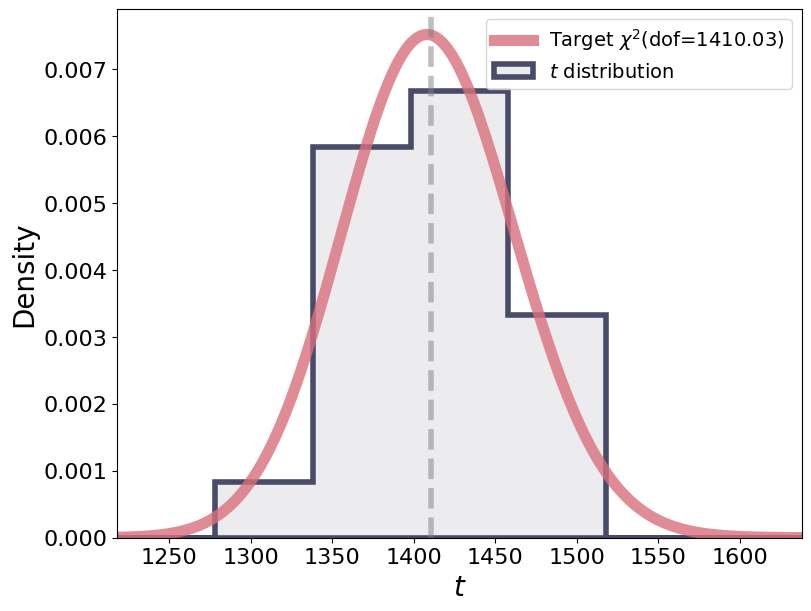

In [115]:

df_fit, loc, scale = chi2.fit(t_list, floc=0, fscale=1)
t_ref_bins  = np.arange(int(np.min(t_list))-100, int(np.max(t_list))+200, 60)
xgrid_ref   = np.arange(int(np.min(t_list))-100, int(np.max(t_list))+200, 2)

ref_chi2 = chi2(df=df_fit)

plot_one_t(
    t_distribution  = t_list,
    t_bins          = t_ref_bins,
    chi2            = ref_chi2,
    chi2_grid       = xgrid_ref,
    show_hist       = True,
    show_error      = False,
    compute_rate    = False,
    err_marker      = "o",
    err_markersize  = 10,
    err_capsize     = 5,
    err_elinewidth  = 4,
    err_capthick    = 4,
    err_color       = "black",
    figsize         = (8, 6),
    fontsize        = 20,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    hist_ecolor     = ("#494B69", 1.0),
    hist_fcolor     = ("#494B69", 0.1),
    chi2_color      = ("#D8707C", 0.8),
    hist_lw         = 4,
    chi2_lw         = 8,
    hist_type       = "stepfilled",
    hist_label      = "$\it{t}$ distribution",
    chi2_label      = "Target $\chi^2$(dof=%.2f)"%(df_fit),
    xlabel          = r"$t$",
    ylabel          = "Density",
    show_plot       = True,
    save_plot       = False,
    plot_name       = "t_distribution",
    # plot_path       = PLOT_PATH,
    plot_format     = "png",
    return_fig      = False,
    plot_w          = False,
    wclip           = None,
)